# MNIST DDPM + DPS Inpainting (Hello World)

What this notebook does:
1) Train a tiny DDPM (noise-prediction) on MNIST (28×28).
2) Define an inpainting operator (mask).
3) Use DPS (likelihood guidance) during the reverse process to sample from the posterior p(x|y).
4) Visualize: original, masked measurement, DPS reconstruction, unconditional baseline.

You can speed this up by reducing steps/epochs or using GPU.


In [26]:
# Cell 1 — Imports & Config
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print("Using device:", device)

# Diffusion hyperparameters
T = 400  # number of diffusion steps


Using device: mps


### Load MNIST Data

In [27]:
# Cell 2 — Dataset & DataLoader (normalized to [-1,1])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # crucial!
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=2, pin_memory=True)


# Diffusion Parameters

In [28]:
# Cell 3 — Diffusion schedule
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)


### Tiny model (barebones CNN)

In [29]:
# Cell 4 — Tiny but robust DDPM model
class TinyDDPM(nn.Module):
    def __init__(self, T, t_dim=32, channels=128):  # bumped channels
        super().__init__()
        self.t_emb = nn.Embedding(T, t_dim)
        self.net = nn.Sequential(
            nn.Conv2d(1 + t_dim, channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, 1, 3, padding=1)
        )

    def forward(self, x, t):
        t_emb = self.t_emb(t).unsqueeze(-1).unsqueeze(-1)
        t_emb = t_emb.expand(-1, -1, x.size(2), x.size(3))
        x_in = torch.cat([x, t_emb], dim=1)
        return self.net(x_in)


In [30]:
class SmallUNet(nn.Module):
    def __init__(self, T, t_dim=32, base_channels=64):
        super().__init__()
        self.t_emb = nn.Embedding(T, t_dim)

        # Down
        self.conv1 = nn.Conv2d(1 + t_dim, base_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(base_channels, base_channels * 2, 4, stride=2, padding=1)

        # Bottleneck
        self.conv3 = nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1)

        # Up
        self.upconv = nn.ConvTranspose2d(base_channels * 2, base_channels, 4, stride=2, padding=1)
        self.conv_out = nn.Conv2d(base_channels * 2, 1, 3, padding=1)  # concat skip

    def forward(self, x, t):
        t_emb = self.t_emb(t).unsqueeze(-1).unsqueeze(-1)
        t_emb = t_emb.expand(-1, -1, x.size(2), x.size(3))
        x_in = torch.cat([x, t_emb], dim=1)

        # Down path
        d1 = F.relu(self.conv1(x_in))
        d2 = F.relu(self.conv2(d1))

        # Bottleneck
        b = F.relu(self.conv3(d2))

        # Up path + skip
        u = F.relu(self.upconv(b))
        u = torch.cat([u, d1], dim=1)
        out = self.conv_out(u)
        return out


In [ ]:
model = SmallUNet(T).to(device)

# Training Model

In [ ]:
T = 400
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)


In [36]:
def cosine_beta_schedule(T, s=0.008):
    """
    Nichol & Dhariwal (2021) cosine schedule.
    f(t) = cos^2((t/T + s)/(1+s) * π/2)
    β_t = 1 - f(t+1)/f(t)
    """
    steps = torch.arange(T + 1, dtype=torch.float64)
    f = torch.cos(((steps / T) + s) / (1 + s) * math.pi / 2) ** 2
    f = f / f[0]  # normalize so that ᾱ_0 = 1
    betas = 1 - (f[1:] / f[:-1])
    return betas.float()


Training Loop

In [37]:
# # Cell 5 — Training loop

# epochs = 10
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# for epoch in range(epochs):
#     model.train()
#     total_loss, count = 0.0, 0
#     for x0, _ in train_loader:
#         x0 = x0.to(device)
#         t = torch.randint(0, T, (x0.size(0),), device=device)
#         noise = torch.randn_like(x0)

#         a_bar = alpha_bars[t].view(-1,1,1,1)
#         x_t = torch.sqrt(a_bar)*x0 + torch.sqrt(1 - a_bar)*noise

#         eps_pred = model(x_t, t)
#         loss = F.mse_loss(eps_pred, noise)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item() * x0.size(0)
#         count += x0.size(0)

#     avg_loss = total_loss / count
#     print(f"Epoch {epoch+1}/{epochs} - avg loss: {avg_loss:.4f}")


epochs = 10
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
for epoch in range(epochs):
    model.train()
    total_loss = 0
    count = 0

    for x0, _ in train_loader:
        x0 = x0.to(device)
        bsz = x0.size(0)

        # Sample t uniformly from [0, T-1]
        t = torch.randint(0, T, (bsz,), device=device)

        # Sample Gaussian noise
        noise = torch.randn_like(x0)

        # Forward diffuse x0 → xt using cosine schedule
        alpha_bar_t = alpha_bars[t].view(-1, 1, 1, 1)
        x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise

        # Predict noise
        pred = model(x_t, t).sample if hasattr(model(x_t, t), "sample") else model(x_t, t)

        # Loss: predict ε
        loss = F.mse_loss(pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * bsz
        count += bsz

    print(f"Epoch {epoch+1}/{epochs} - avg loss: {total_loss / count:.4f}")



Epoch 1/10 - avg loss: 0.0478
Epoch 2/10 - avg loss: 0.0473
Epoch 3/10 - avg loss: 0.0469
Epoch 4/10 - avg loss: 0.0462
Epoch 5/10 - avg loss: 0.0465


libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10ddb0a40>
Traceback (most recent call last):
  File "/Users/azhir/miniconda3/envs/jax_cfd/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/Users/azhir/miniconda3/envs/jax_cfd/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1628, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/azhir/miniconda3/envs/jax_cfd/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/azhir/miniconda3/envs/jax_cfd/lib/python3.11/multiprocessing/popen_fork.py", line 43, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 

KeyboardInterrupt: 

In [38]:
@torch.no_grad()
def predict_x0(x_t, t, eps_pred):
    a_bar = alpha_bars[t].view(-1, 1, 1, 1)
    return (x_t - torch.sqrt(1 - a_bar) * eps_pred) / torch.sqrt(a_bar)

@torch.no_grad()
def ddim_sample(model, n=8, steps=100):
    """
    Deterministic DDIM sampling loop (T→0) using current alpha_bars.
    """
    model.eval()
    x = torch.randn(n, 1, 28, 28, device=device)
    ts = torch.linspace(T-1, 0, steps, device=device).long()

    for i, t_val in enumerate(ts):
        t = t_val.expand(n)
        eps_pred = model(x, t).sample if hasattr(model(x, t), "sample") else model(x, t)
        x0_hat = predict_x0(x, t, eps_pred)
        if i == steps - 1:
            x = x0_hat
        else:
            t_next = ts[i+1].expand(n)
            a_bar_next = alpha_bars[t_next].view(-1,1,1,1)
            x = torch.sqrt(a_bar_next) * x0_hat + torch.sqrt(1 - a_bar_next) * eps_pred

    return x.clamp(-1, 1)

def to_img(x): 
    return (x.clamp(-1, 1) + 1) / 2


In [39]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

epochs = 10
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    count = 0

    for x0, _ in train_loader:
        x0 = x0.to(device)
        bsz = x0.size(0)

        # Sample t uniformly from [0, T-1]
        t = torch.randint(0, T, (bsz,), device=device)

        # Sample Gaussian noise
        noise = torch.randn_like(x0)

        # Forward diffuse x0 → xt using cosine schedule
        alpha_bar_t = alpha_bars[t].view(-1, 1, 1, 1)
        x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise

        # Predict noise
        pred = model(x_t, t).sample if hasattr(model(x_t, t), "sample") else model(x_t, t)

        # Loss: predict ε
        loss = F.mse_loss(pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * bsz
        count += bsz

    avg_loss = total_loss / count
    print(f"Epoch {epoch+1}/{epochs} - avg loss: {avg_loss:.4f}")

    # Generate DDIM samples every 2 epochs
    if (epoch + 1) % 2 == 0 or (epoch + 1) == epochs:
        samples = ddim_sample(model, n=8, steps=100)
        samples = to_img(samples)

        plt.figure(figsize=(12, 2))
        for i in range(samples.size(0)):
            plt.subplot(1, samples.size(0), i + 1)
            plt.imshow(samples[i, 0].cpu(), cmap='gray')
            plt.axis('off')
        plt.suptitle(f"DDIM samples after epoch {epoch+1}", y=1.05)
        plt.tight_layout()
        plt.show()


Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "<string>", line 1, in <module>
  File "/Users/azhir/miniconda3/envs/jax_cfd/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
  File "/Users/azhir/miniconda3/envs/jax_cfd/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
    exitcode = _main(fd, parent_sentinel)
                           ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^
  File "/Users/azhir/miniconda3/envs/jax_cfd/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
  File "/Users/azhir/miniconda3/envs/jax_cfd/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
    self = reduction.pickle.load(from_parent)
                  ^ ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^
  File "/Users/azhir/miniconda3/envs/jax_cfd/lib/python3.11/site-p

RuntimeError: DataLoader worker (pid(s) 58417) exited unexpectedly

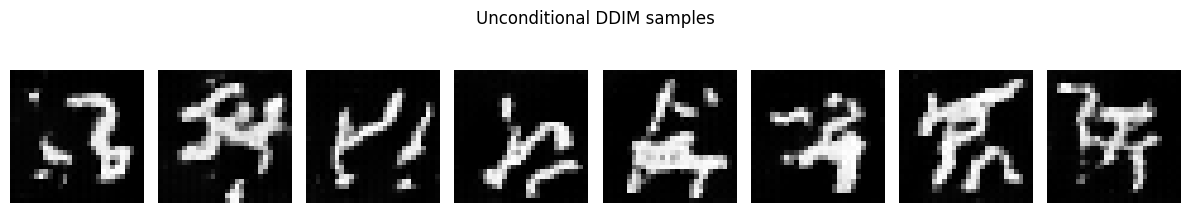

In [35]:
# Cell 6 — Deterministic DDIM sampling

@torch.no_grad()
def predict_x0(x_t, t, eps_pred):
    a_bar = alpha_bars[t].view(-1,1,1,1)
    return (x_t - torch.sqrt(1 - a_bar)*eps_pred) / torch.sqrt(a_bar)

@torch.no_grad()
def ddim_sample(model, n=8, steps=100):
    model.eval()
    x = torch.randn(n, 1, 28, 28, device=device)
    ts = torch.linspace(T-1, 0, steps, device=device).long()
    for i, t_val in enumerate(ts):
        t = t_val.expand(n).to(device)
        eps_pred = model(x, t)
        x0_hat = predict_x0(x, t, eps_pred)
        if i == steps - 1:
            x = x0_hat
        else:
            t_next = ts[i+1].expand(n)
            a_bar_next = alpha_bars[t_next].view(-1,1,1,1)
            x = torch.sqrt(a_bar_next)*x0_hat + torch.sqrt(1 - a_bar_next)*eps_pred
    return x.clamp(-1,1)


# Visualize generated samples
samples = ddim_sample(model, n=8, steps=400)
def to_img(x): return (x.clamp(-1,1)+1)/2

plt.figure(figsize=(12,2))
for i in range(samples.size(0)):
    plt.subplot(1, samples.size(0), i+1)
    plt.imshow(to_img(samples[i,0]).cpu(), cmap='gray'); plt.axis('off')
plt.suptitle("Unconditional DDIM samples", y=1.05)
plt.tight_layout(); plt.show()


In [ ]:
@torch.no_grad()
def sample(model, n=16):
    model.eval()
    x = torch.randn((n, 1, 28, 28), device=device)
    for t in reversed(range(T)):
        t_batch = torch.tensor([t] * n, device=device)

        # Predict noise
        eps_theta = model(x, t_batch).sample if hasattr(model(x, t_batch), "sample") else model(x, t_batch)

        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        beta_t = betas[t]

        # Reverse DDPM step
        x = (1 / torch.sqrt(alpha_t)) * (x - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * eps_theta)

        if t > 0:
            z = torch.randn_like(x)
            x = x + torch.sqrt(beta_t) * z

    return x


# Visualize generated samples
samples = ddim_sample(model, n=8, steps=400)
def to_img(x): return (x.clamp(-1,1)+1)/2

plt.figure(figsize=(12,2))
for i in range(samples.size(0)):
    plt.subplot(1, samples.size(0), i+1)
    plt.imshow(to_img(samples[i,0]).cpu(), cmap='gray'); plt.axis('off')
plt.suptitle("Unconditional DDIM samples", y=1.05)
plt.tight_layout(); plt.show()
